### Цель работы: изучение принципов построения информационных систем с использованием метрических методов классификации.

### Основные задачи:
- изучение инструментария Python для реализации алгоритмов метрической классификации;
- изучение методов оптимизации параметров метрической классификации;
- освоение модификаций kNN-метода.

Для работы был взят массив данных о погоде '6 class csv.csv' (https://www.kaggle.com/datasets/deepu1109/star-dataset). Набор данных из 6 звездных классов для классификации звезд

### Описание колонок:

* Absolute Temperature - Абсолютная температура
* Relative Luminosity - Относительная светимость
* Relative Radius - Относительный радиус
* Absolute Magnitude - Абсолютная величина
* Star Color (white,Red,Blue,Yellow,yellow-orange etc) - Цвет звезды
* Spectral Class (O,B,A,F,G,K,M) - Спектральный класс
* Star Type (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence,SuperGiants, HyperGiants) - Тип звезды (целевая переменная)

Считаем данные и начнем работу с датасетом:

In [1]:
import pandas as pd

data = pd.read_csv('6 class csv.csv')
print(data.shape)
data.head()

(240, 7)


C:\Users\nastya-pls\AppData\Local\Temp\ipykernel_19088\767715138.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


## Первичный анализ датасета

Проверим структуру данных каждого признака и статистические характеристики:

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


Всего категориальных 2 признака - Star color, Spectral Class;

5 количественных признака - Temperature (K), Luminosity(L/Lo), Radius(R/Ro), Absolute magnitude(Mv) 

In [3]:
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


По данной статистической характеристике можем заметить, что выбросов в данных нет

In [4]:
data.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

Пропусков в датасете также не наблюдается, потому мы можем чистить датасет, а сразу перейти к выявлению зависимостей признаков.

Построим график, отображающий распределение объектов попарно по различным признакам с указанием признака нашей целевой переменной "Star type"

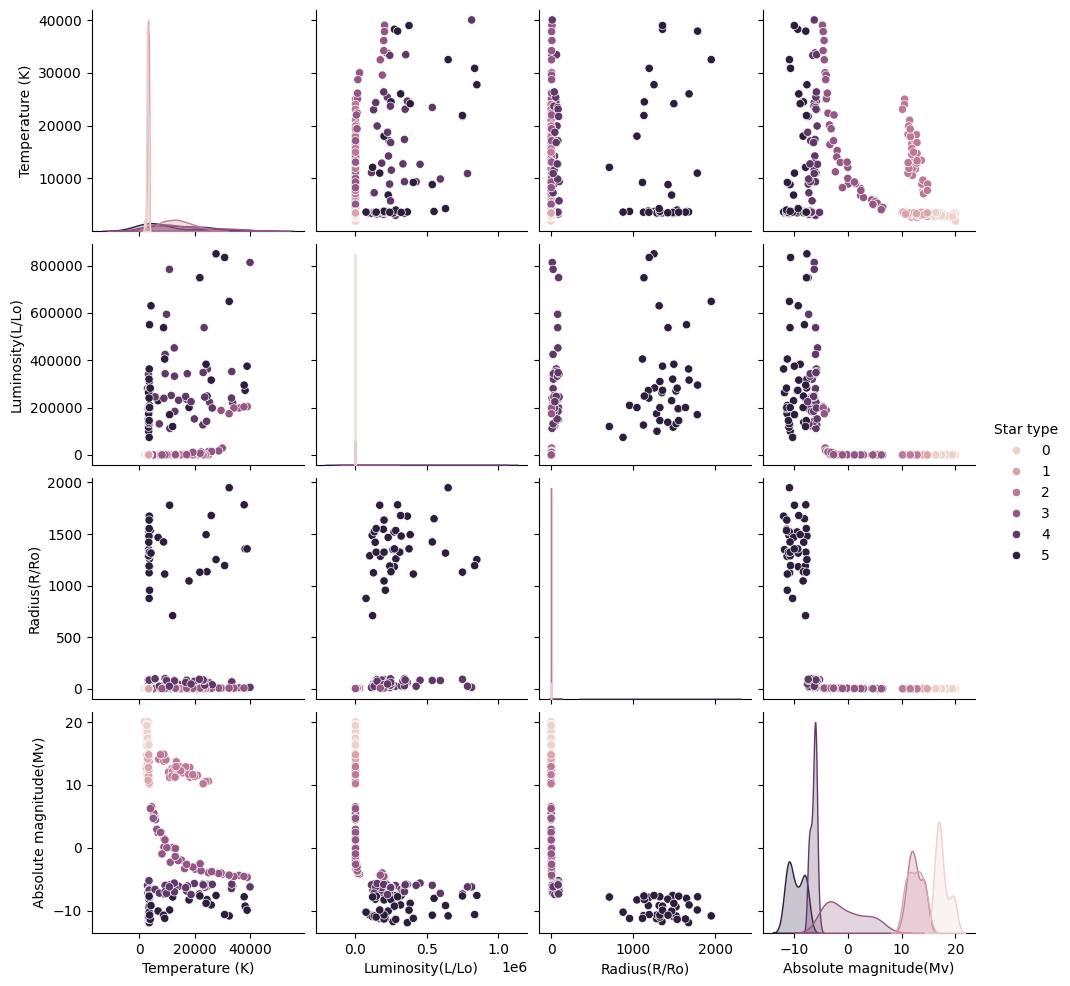

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.pairplot(data, hue='Star type')
plt.show()

На данном графике мы можем отметить явное разбиение признаков по классам у признаков Temperature (K) и Absolute magnitude(Mv), поэтому более подробно рассмотрим эту зависимость с помощью диаграммы рассеивания

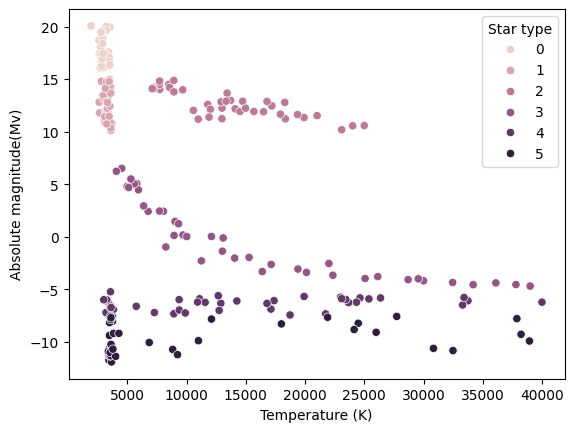

In [6]:
sns.scatterplot(data=data, x='Temperature (K)', y='Absolute magnitude(Mv)', hue='Star type')
plt.show()

На данном графике мы видим явное разделение данных на 6 групп, характеризующих типы звезд, поэтому в дальнейшем будем рассматривать именно эту взаимосвязь для категоризации признаков.

Также возможно стоит рассмотреть разделение на классы категориальных признаков. Для этого нам понадобится закодировать эти признаки, а уже после строить диаграмму рассеивания

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder_color = LabelEncoder()
data['Star color'] = label_encoder_color.fit_transform(data['Star color'])

label_encoder_type = LabelEncoder()
data['Spectral Class'] = label_encoder_type.fit_transform(data['Spectral Class'])

data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,10,5
1,3042,0.000500,0.1542,16.60,0,10,5
2,2600,0.000300,0.1020,18.70,0,10,5
3,2800,0.000200,0.1600,16.65,0,10,5
4,1939,0.000138,0.1030,20.06,0,10,5


Закодировав категориальные признаки, мы имеем возможность посмотреть есть ли смысл категоризовать данные уже по двум новым признакам - Star color и Spectral Class. Посмотрим это на диаграммах рассеивания с указанием признаков Star color и Spectral Class

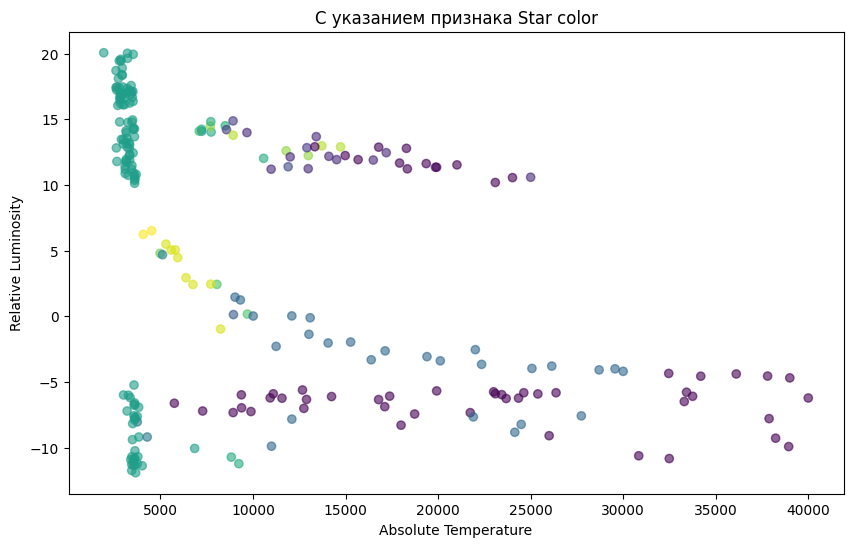

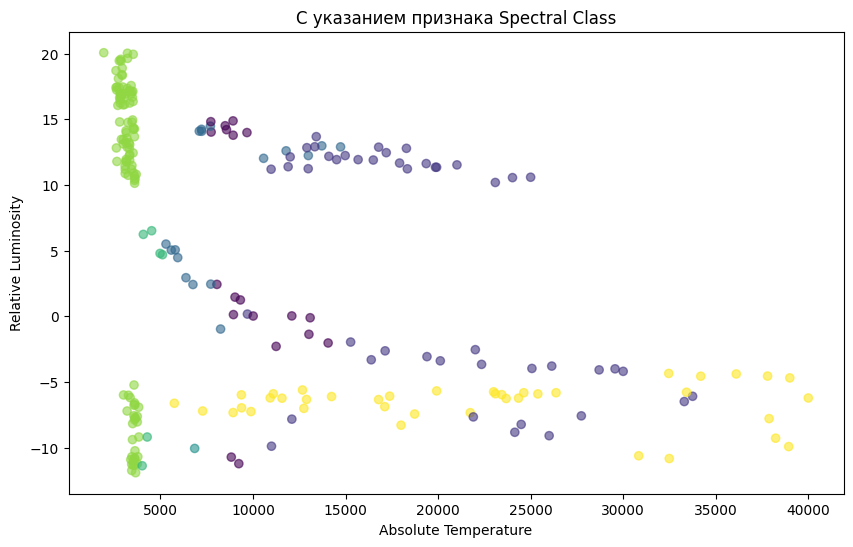

In [23]:
plt.figure(1,figsize=(10, 6))
plt.scatter(data['Temperature (K)'], data['Absolute magnitude(Mv)'], 
            c=data['Star color'], label='Star color', alpha=0.6)
plt.xlabel('Absolute Temperature')
plt.ylabel('Relative Luminosity')
plt.title('С указанием признака Star color')

plt.figure(2,figsize=(10, 6))
plt.scatter(data['Temperature (K)'], data['Absolute magnitude(Mv)'], 
            c=data['Spectral Class'], label='Spectral Class', alpha=0.6)
plt.xlabel('Absolute Temperature')
plt.ylabel('Relative Luminosity')
plt.title('С указанием признака Spectral Class')
plt.show()

На данных графиках можем заметить, что распределение данных по признакам изменилось. 
В данных диаграммах рассеивания группы, на которые можно разделить данные не сильно прослеживаются, многие классы смешиваются между собой. Поэтому рассматривать эти признаки как основные признаки классификации не следуюет и можем продолжить построение модели классификации уже для нашей целевой переменной - Star Type

Во время первичного анализа датасета полезно проверять все взаимосвязи признаков, поэтому выведем матрицу корреляций и посмотрим наблюдается ли линейная зависимость признаков

In [27]:
data.corr()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
Temperature (K),1.000000,0.393404,0.064216,-0.420261,0.411129,-0.697438,-0.207852
Luminosity(L/Lo),0.393404,1.000000,0.526516,-0.692619,0.676845,-0.393509,0.275280
Radius(R/Ro),0.064216,0.526516,1.000000,-0.608728,0.660975,-0.000818,0.097124
Absolute magnitude(Mv),-0.420261,-0.692619,-0.608728,1.000000,-0.955276,0.333552,-0.085840
Star type,0.411129,0.676845,0.660975,-0.955276,1.000000,-0.317103,-0.049131
Star color,-0.697438,-0.393509,-0.000818,0.333552,-0.317103,1.000000,-0.006298
Spectral Class,-0.207852,0.275280,0.097124,-0.085840,-0.049131,-0.006298,1.000000


<Axes: >

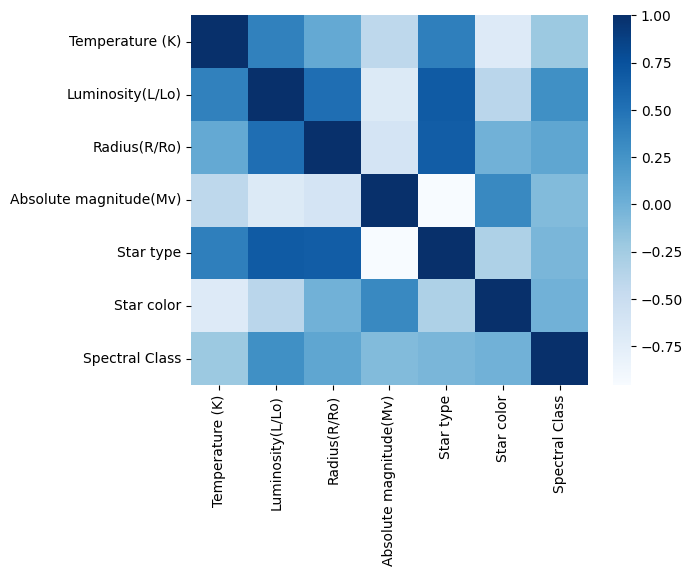

In [26]:
sns.heatmap(data.corr(), cmap = plt.cm.Blues)

Как мы видим по диаграмме, у некоторых признаков прослеживается сильная корреляция (около 0,7), что будет полезно для будущей модели

## Построение модели классификации

Воспользуемся методом ближайших соседей для построения модели классификации. Так как мы уже закодировали категориальные переменные, сразу воспользуемся библиотекой scikit для построения классификатора:

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Определение признаков и целевой переменной
X = data[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)','Star color','Spectral Class']]
y = data['Star type']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание классификатора
model = KNeighborsClassifier(n_neighbors=6) 
# Обучение классификатора
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)
print(y_pred)

[2 0 3 4 5 4 4 2 0 2 5 2 5 4 5 4 0 1 2 1 0 0 4 3 4 3 1 2 4 2 3 4 2 0 0 0 0
 4 1 4 4 4 5 0 3 0 5 3]


На выходе мы получили предсказанные метки данных - типы звезд наших планет. Давайте оценим правильность работы нашей модели с помощью метода confusion_matrix или матрицы ошибок.

In [49]:
confusion_matrix(y_test, y_pred)

array([[7, 1, 0, 0, 0, 0],
       [4, 3, 0, 0, 0, 0],
       [0, 0, 6, 0, 0, 0],
       [0, 0, 2, 6, 0, 0],
       [0, 0, 0, 0, 4, 4],
       [0, 0, 0, 0, 9, 2]], dtype=int64)

Данная матрица описывает нам разницу сколько ошибок произошло при предсказании модели классов на тестовой выборке.

По ней мы можем сделать следующие выводы:
1. Класс 0:

   • Верно предсказано: 7 (первый элемент на главной диагонали)
   • Неправильно предсказано: 1 (объект класса 0 был ошибочно классифицирован как класс 1)

2. Класс 1:

   • Верно предсказано: 3
   • Неправильно предсказано: 4 (объекты класса 1 были ошибочно классифицированы как класс 0)

3. Класс 2:

   • Верно предсказано: 6
   • Неправильно предсказано: 0 (все объекты класса 2 были правильно классифицированы)

4. Класс 3:

   • Верно предсказано: 6
   • Неправильно предсказано: 2 (объекты класса 3 были ошибочно классифицированы как класс 2)

5. Класс 4:

   • Верно предсказано: 4
   • Неправильно предсказано: 4 (объекты класса 4 были ошибочно классифицированы как класс 5)

6. Класс 5:

   • Верно предсказано: 2
   • Неправильно предсказано: 9 (объекты класса 5 были ошибочно классифицированы как класс 4)
   
Благодаря нашему первичному анализу мы можем сделать вывод, что данные ошибки в предсказании последних двух классов происходят в виду их сильной близости друг к другу, что можно отметить и на диаграмме рассеивания, построенной выше. А потому данный датасет может не совсем подходить для данной задачи классификации методом K ближайших соседей, так как классы в нем находятся на достаточно близком расстоянии друг к другу и не явно отделены в группы из-за чего возникают ошибки в предсказании меток

Всего у нас может быть 6 классов - это было нам подсказано в исходном датасете, но давайте проверим, какое оптимальное количество классов может дать нам модель. Для этого будем использовать простейшую оценку качества hold-out:

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)
model_pred = model.predict(X_holdout)
accur = accuracy_score(y_holdout,model_pred)
print("accuracy 1:", accur)

accuracy: 0.5694444444444444


Попробуем изменить доли выборок и оценить результаты:

Test size: 0.1, Accuracy: 0.7500
Test size: 0.2, Accuracy: 0.5833
Test size: 0.3, Accuracy: 0.5753
Test size: 0.4, Accuracy: 0.6042


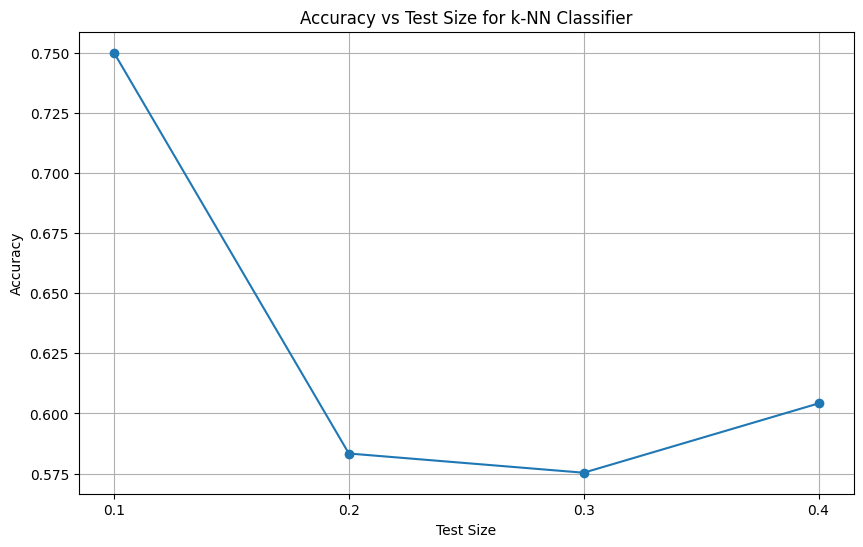

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

test_sizes = np.arange(0.1, 0.5, 0.1) 
accuracies = []

for test_size in test_sizes:
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=test_size, random_state=42)
    model = KNeighborsClassifier(n_neighbors=6)
    model.fit(X_train, y_train)
    model_pred = model.predict(X_holdout)
    accur = accuracy_score(y_holdout, model_pred)
    accuracies.append(accur)
    print(f"Test size: {test_size:.1f}, Accuracy: {accur:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(test_sizes, accuracies, marker='o')
plt.title('Accuracy vs Test Size for k-NN Classifier')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.xticks(test_sizes)
plt.grid()
plt.show()


С изменением доли тестовой и тренировочной выборки accuracy изменяется скачками. Наибольшее значение accuracy наблюдается при разделении выборки 10:90 (тестовая:тренировочная), однако это может привести к переобучению модели на тренировочной выборке. Наиболее подходящим является вариант с разделением выборки 40 на 60 (тестовая:тренировочная) и 20 на 80 (тестовая:тренировочная), так как меньше шанс на переобучение модели у второго варианта доли выборок, то будем пользоваться им

In [63]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy или точность, которая отражает долю правильно спрогнозированных классов среди всех образцов имеет достаточно низкое значение, что не достаточно хорошо для модели. Попробуем поэксперементировать с изменением количества соседей и проверкой accuracy:

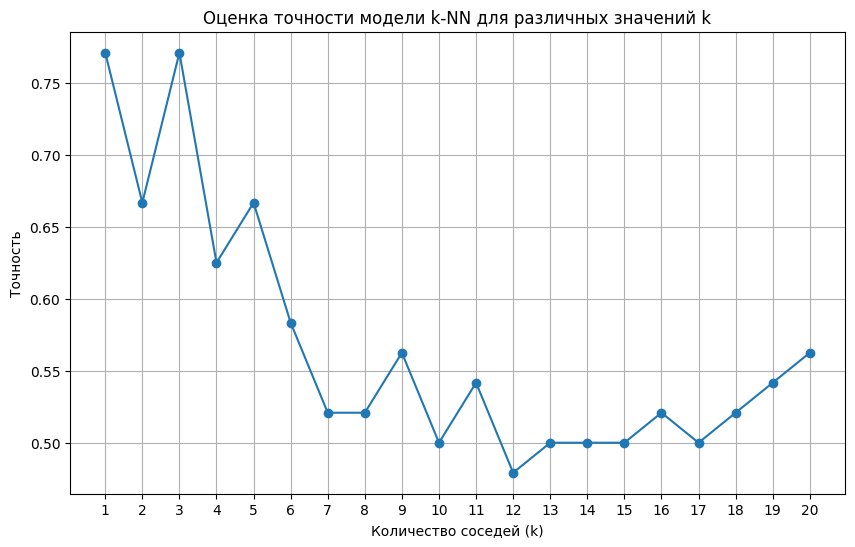

Оптимальное количество соседей (k): [1, 3]


In [64]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Оценка точности модели k-NN для различных значений k')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.xticks(k_values)
plt.grid()
plt.show()

# Вывод оптимального k
k_max = max(accuracies)
all_k_max = []
for i in range(len(accuracies)):
    if accuracies[i] >= k_max:
        all_k_max.append(k_values[i])
print(f'Оптимальное количество соседей (k): {all_k_max}')

При данной оценке видим, что точность нашей модели будем максимальна при 1 или 3 группах, что является плохим результатом для модели кластеризации. Одним из оптимальных вариантов будет выбрать 5 групп, так как тогда сохранится неплохая оценка accuracy (около 0,67). Это также можно будет обосновать тем, что среди 6 типов планет (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence,SuperGiants, HyperGiants) у нас наблюдается две планеты-Гиганта, которые схожи по своим признакам и могут быть определены в одну группу

Попробуем оценить модель другим способом - с помощью cross_val_score и изменения количества соседей:

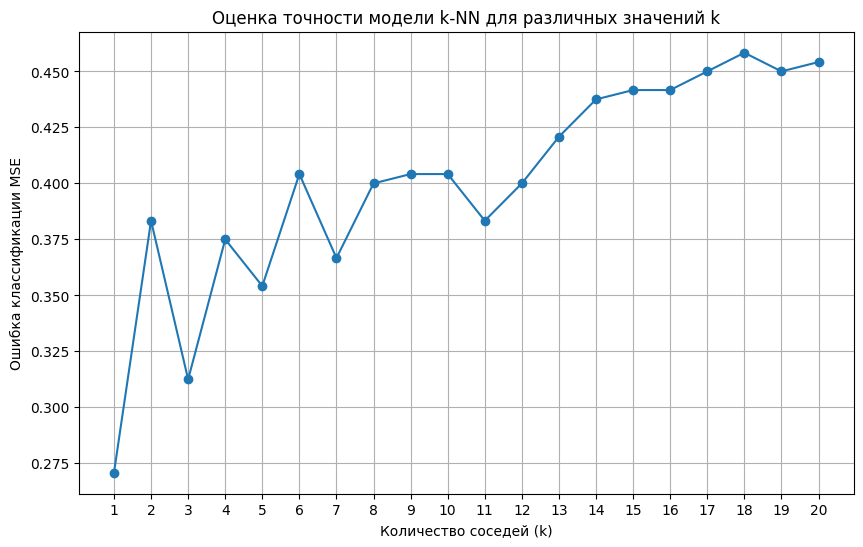

Оптимальное количество соседей (k): [1]


In [65]:
from sklearn.model_selection import cross_val_score

k_values = range(1, 21)
cv_score = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

MSE = [1-x for x in cv_score]

plt.figure(figsize=(10, 6))
plt.plot(k_values, MSE, marker='o')
plt.title('Оценка точности модели k-NN для различных значений k')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Ошибка классификации MSE')
plt.xticks(k_values)
plt.grid()
plt.show()

k_min = min(MSE)
all_k_mins = []
for i in range(len(MSE)):
    if MSE[i] <= k_min:
        all_k_mins.append(k_values[i])
print(f'Оптимальное количество соседей (k): {all_k_mins}')

Данная классификация также указала нам на не самые лучшие характеристики датасета - оптимальным количеством соседей является 1, что объединяет все данные в одну группу и не является задачей классификации. Однако, по этому графику мы можем также отметить оптимальный вариант - 5 групп, так как при этом значении мы приближаемся к теоретической точности определения количества групп(6 групп) и к улучшению точности модели (ошибка превышает минимальную на несколько сотых)

График подсказывает, что качество модели по валидационным метрикам продолжает расти, имеет смысл добавить новые данные в датасет, чтобы увеличить точность модели, или же выбрать оптимальный вариант групп - 5, чтобы соблюсти теоретическую и метрическую оценку необходимого количества групп

Давайте теперь попробуем вычислить оценку cross validation для различных значений fold (количества подмножеств при кросс-
валидации):

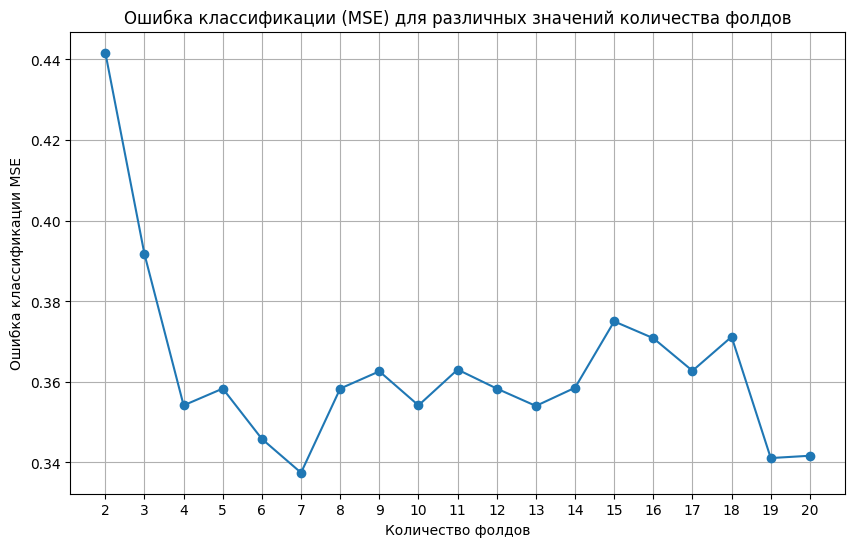

Оптимальное количество фолдов: [7]


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier


folds = range(2, 21) 
cv_scores = []

for n_folds in folds:
    model = KNeighborsClassifier(n_neighbors=5)  
    scores = cross_val_score(model, X, y, cv=n_folds, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

plt.figure(figsize=(10, 6))
plt.plot(folds, MSE, marker='o')
plt.title('Ошибка классификации (MSE) для различных значений количества фолдов')
plt.xlabel('Количество фолдов')
plt.ylabel('Ошибка классификации MSE')
plt.xticks(folds)
plt.grid()
plt.show()

# Определение оптимального количества фолдов
min_MSE = min(MSE)
optimal_folds = [folds[i] for i in range(len(MSE)) if MSE[i] == min_MSE]
print(f'Оптимальное количество фолдов: {optimal_folds}')


Оптимальным количеством в данной оценке является - 7 групп, при этом 6 и 19 групп также имеют хорошие характеристики.

Таким образом, мы можем сделать вывод о выборе оптимального количества групп для классификации датасета типов планет:
Наиболее подходящими вариантом количества групп является 5-7 групп, что позволяет нам вернуться к нашему исходному количеству типов планет, указанному в изначальном датасете, а именно к 6 группам, и пользоваться моделью классификации, написанной ранее

## Заключение

В результате работы был проведен первичный анализ датасета, проведены метрические классификации для модели классификации, 
проведены методы оптимизации параметров метрической классификации, проведены модификации kNN-метода